Test the rsults based on some Deterministic methods.

# Test the rules

In [5]:
from feature_selection import vectorize_by_compaction_output_level
from main import load_log_and_qps
from traversal import get_log_dirs, get_log_and_std_files
log_prefix_dir = "log_files"
dirs = get_log_dirs(log_prefix_dir)

In [6]:
log_dir = dirs[0]
stdout_file, LOG_file, report_csv = get_log_and_std_files(log_dir)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

1599571593036903


In [7]:
import numpy as np
observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

In [9]:
# Use HMM to divide the data first

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
from tensorflow_probability import  distributions as tfd
from matplotlib import pylab as plt

In [12]:
# Train the HMM states
fitting_area = observed_counts

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

    # Give probability exp(-100) ~= 0 to states outside of the current model.
    initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
    initial_state_logits[:num_states] = 0.
    initial_state_logits[0] = 1.
    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    transition_probs = np.eye(max_num_states, dtype=np.float32)
    if num_states > 1:
        transition_probs[:num_states, :num_states] = (
                daily_change_prob / (num_states - 1))
        np.fill_diagonal(transition_probs[:num_states, :num_states],
                         1 - daily_change_prob)
    return initial_state_logits, transition_probs

max_num_states=10
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states + 1):
    initial_state_logits, transition_probs = build_latent_state(
        num_states=num_states,
        max_num_states=max_num_states)
    batch_initial_state_logits.append(initial_state_logits)
    batch_transition_probs.append(transition_probs)
batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)

trainable_log_rates = tf.Variable(
    (np.log(np.mean(fitting_area)) *
     np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
     tf.random.normal([1, max_num_states])),
    name='log_rates')

hmm = tfd.HiddenMarkovModel(
    initial_distribution=tfd.Categorical(
        logits=batch_initial_state_logits),
    transition_distribution=tfd.Categorical(probs=batch_transition_probs),
    observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
    num_steps=len(fitting_area))
rate_prior = tfd.LogNormal(5, 5)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

def log_prob():
    prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
    prior_lp = tf.stack(
        [tf.reduce_sum(prior_lps[i, :i + 1]) for i in range(max_num_states)])
    return prior_lp + hmm.log_prob(fitting_area)

@tf.function(autograph=False)
def train_op():
    with tf.GradientTape() as tape:
        neg_log_prob = -log_prob()
    grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
    optimizer.apply_gradients([(grads, trainable_log_rates)])
    return neg_log_prob, tf.math.exp(trainable_log_rates)

for step in range(201):
    loss, rates = [t.numpy() for t in train_op()]
    if step % 20 == 0:
        print("step {}: loss {}".format(step, loss))


/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: loss [81415610. 81415624. 48677910. 31299226. 31299298. 11664289. 10565487.
 10413891. 10357199.  8288659.]
step 20: loss [81363420.  40596160.   8088534.5  7081389.5  6443276.   4587974.
  2874711.2  2729796.5  2366517.8  1971378.2]
step 40: loss [81349470.  13225035.   7915103.5  5546173.   4595929.   3210694.
  1849089.8  1546768.9  1358988.4  1127831.8]
step 60: loss [81348250.  12735787.   7806976.5  4893868.   3764998.2  2436626.5
  1495859.2  1252724.5  1022183.5   885352.7]
step 80: loss [81348264.  12305889.   7754674.5  4825015.   3571973.2  1951379.
  1352333.2  1118348.4   904880.1   781230.4]
step 100: loss [81348210.   12293493.    7754210.5   4819016.5   3421500.2   1751218.2
  1286321.5   1046472.06   838025.25   723012.9 ]
step 120: loss [81348380.   12285296.    7753601.    4818031.5   3171996.2   1675504.2
  1244742.    1004113.44   797786.6    686343.1 ]
step 140: loss [81348376.  12285328.   7753508.5  4817993.5  2972031.   1632023.5
  1218359.5   975431.3 

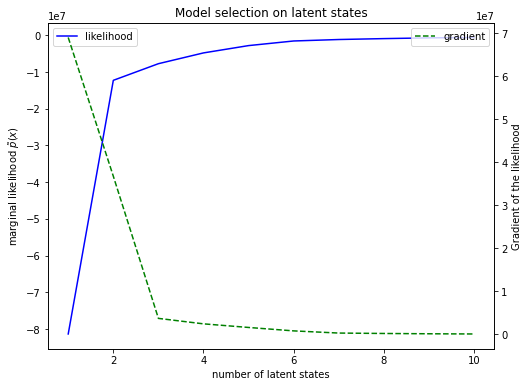

In [14]:
num_states = np.arange(1, max_num_states + 1)
fig = plt.figure(figsize=(8, 6))
plt.plot(num_states, -loss, "b-", label="likelihood")
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.legend()
plt.twinx()
plt.plot(num_states, np.gradient(-loss), "g--", label="gradient")
plt.ylabel("Gradient of the likelihood")
plt.title("Model selection on latent states")
plt.legend()
plt.show()

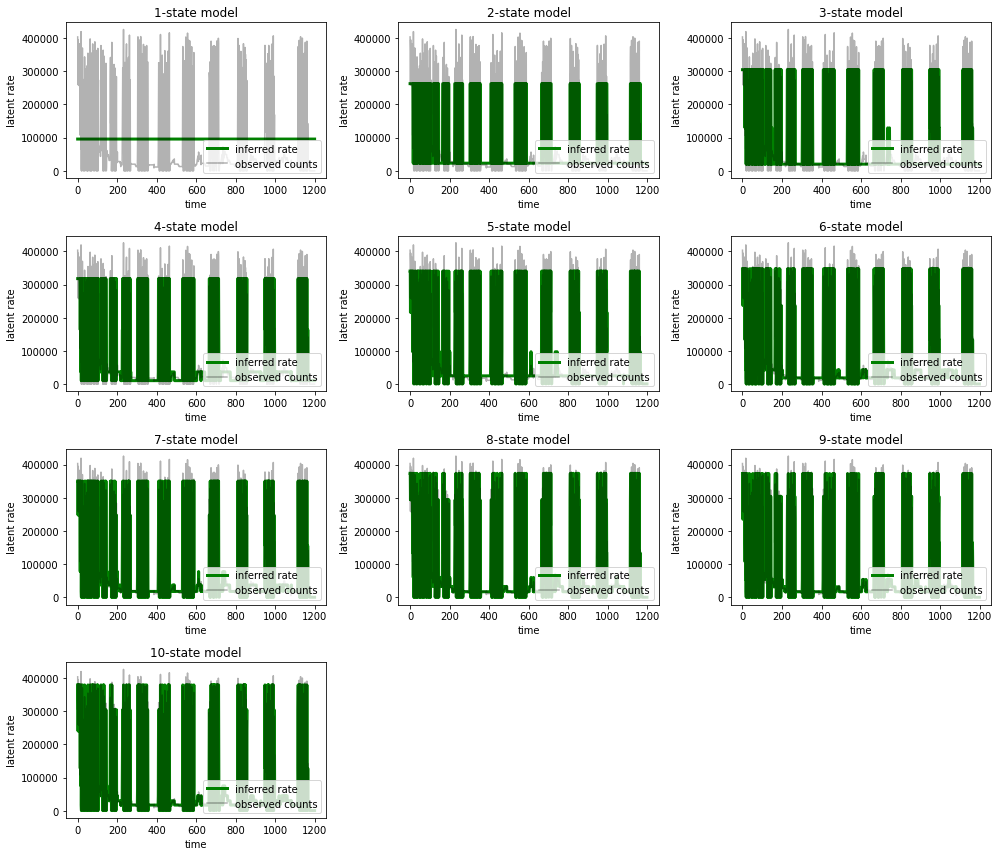

In [15]:
posterior_probs = hmm.posterior_marginals(
    fitting_area).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
    ax = fig.add_subplot(4, 3, i + 1)
    ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
    ax.plot(fitting_area, c='black', alpha=0.3, label='observed counts')
    ax.set_ylabel("latent rate")
    ax.set_xlabel("time")
    ax.set_title("{}-state model".format(i + 1))
    ax.legend(loc=4)
plt.tight_layout()
plt.show()

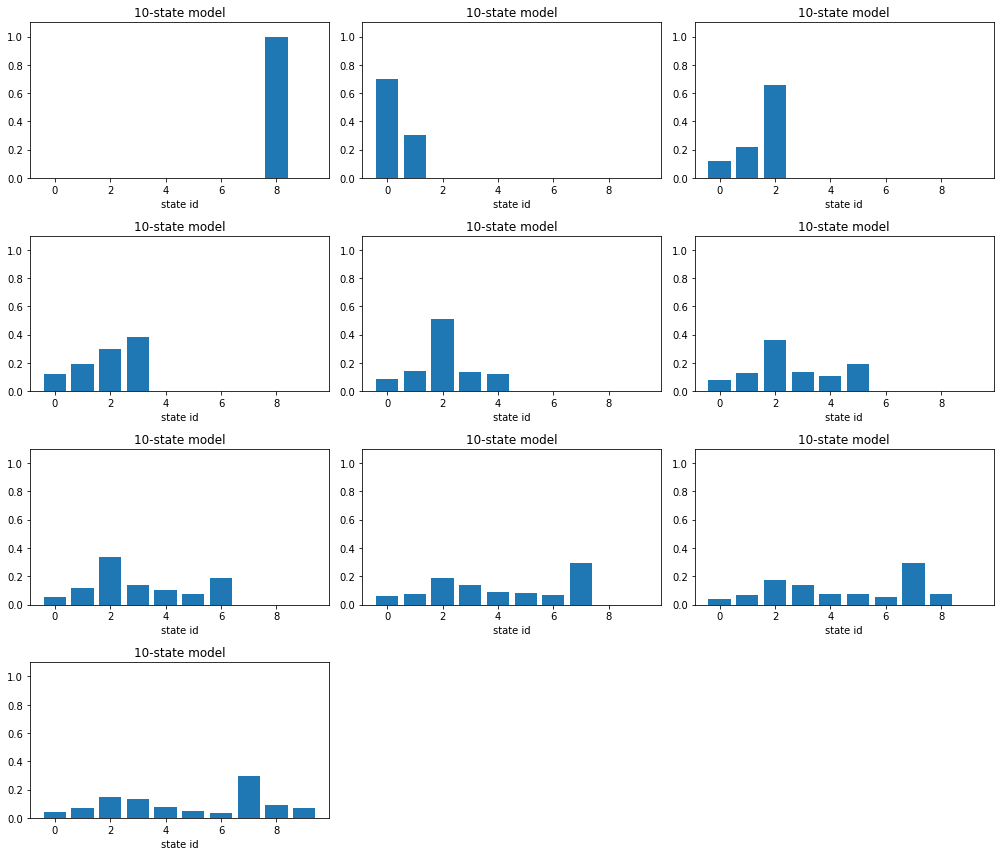

In [76]:
def autolabel(rects,infer_rates):
    """Attach a text label above each bar in *rects*, displaying its height."""
    index = 0
    for rect in rects:
        height = infer_rates[index]
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index+=1
    pass

fig = plt.figure(figsize=(14,12))
list_of_moment_map = []
for number_of_states in range(max_num_states):
    moment_map = {}
    ax = fig.add_subplot(4,3,number_of_states+1)
    for state_no in range(max_num_states):
        moment_map[state_no] = []

    index = 0
    for state in most_probable_states[number_of_states]:
        moment_map[state].append(index)
        index+=1
    # moment_map = {k:v for k,v in moment_map.items() if len(v) > 0}
    frequency_count = [len(moment_map[x]) / index for x in moment_map]
    bar1 = ax.bar(range(len(moment_map)),frequency_count)
    # autolabel(bar1,most_probable_states[number_of_states])
    ax.set_ylim(0,1.1)
    ax.set_xlabel("state id")
    ax.set_title("{}-state model".format(i + 1))
    list_of_moment_map.append(moment_map)
plt.tight_layout()
plt.show()

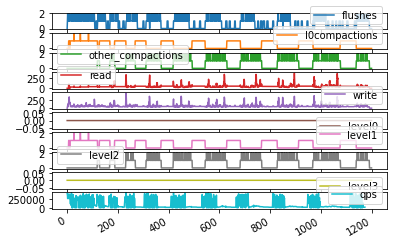

In [87]:
moment_map = list_of_moment_map[0]

for moment_list in moment_map:
    if len(moment_map[moment_list]) >0:
        # bucket_df[moment_map[moment_list]]
        selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
        selected_df.plot(subplots=True)
        # bucket_df["qps"][moment_map[moment_list]].plot()

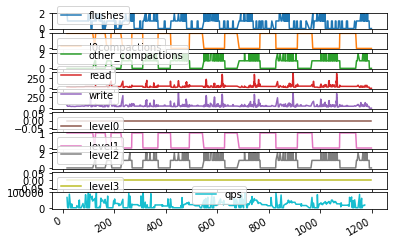

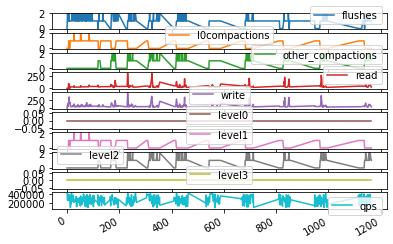

In [89]:
moment_map = list_of_moment_map[1]

for moment_list in moment_map:
    if len(moment_map[moment_list]) >0:
        # bucket_df[moment_map[moment_list]]
        selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
        selected_df.plot(subplots=True)
        # bucket_df["qps"][moment_map[moment_list]].plot()

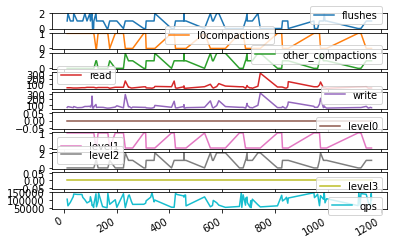

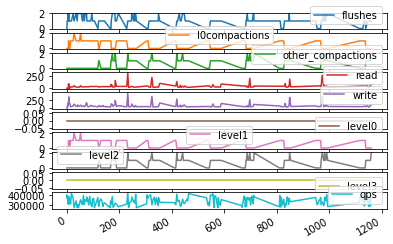

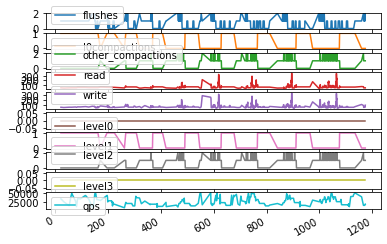

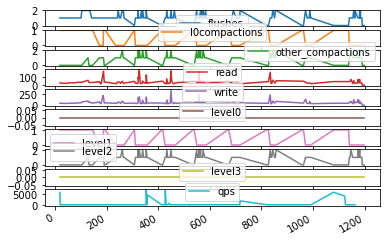

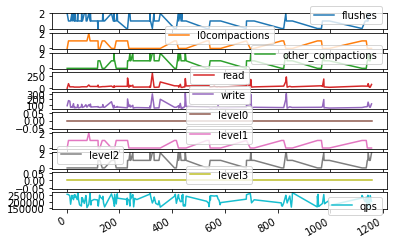

In [90]:
moment_map = list_of_moment_map[4]

for moment_list in moment_map:
    if len(moment_map[moment_list]) >0:
        # bucket_df[moment_map[moment_list]]
        selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
        selected_df.plot(subplots=True)
        # bucket_df["qps"][moment_map[moment_list]].plot()

In [106]:
dirs[15]

def get_list_of_moment_map(fitting_area):
    def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

        # Give probability exp(-100) ~= 0 to states outside of the current model.
        initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
        initial_state_logits[:num_states] = 0.
        initial_state_logits[0] = 1.
        # Build a transition matrix that transitions only within the current
        # `num_states` states.
        transition_probs = np.eye(max_num_states, dtype=np.float32)
        if num_states > 1:
            transition_probs[:num_states, :num_states] = (
                    daily_change_prob / (num_states - 1))
            np.fill_diagonal(transition_probs[:num_states, :num_states],
                             1 - daily_change_prob)
        return initial_state_logits, transition_probs

    max_num_states=10
    batch_initial_state_logits = []
    batch_transition_probs = []
    for num_states in range(1, max_num_states + 1):
        initial_state_logits, transition_probs = build_latent_state(
            num_states=num_states,
            max_num_states=max_num_states)
        batch_initial_state_logits.append(initial_state_logits)
        batch_transition_probs.append(transition_probs)
    batch_initial_state_logits = np.array(batch_initial_state_logits)
    batch_transition_probs = np.array(batch_transition_probs)

    trainable_log_rates = tf.Variable(
        (np.log(np.mean(fitting_area)) *
         np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
         tf.random.normal([1, max_num_states])),
        name='log_rates')

    hmm = tfd.HiddenMarkovModel(
        initial_distribution=tfd.Categorical(
            logits=batch_initial_state_logits),
        transition_distribution=tfd.Categorical(probs=batch_transition_probs),
        observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
        num_steps=len(fitting_area))
    rate_prior = tfd.LogNormal(5, 5)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    def log_prob():
        prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
        prior_lp = tf.stack(
            [tf.reduce_sum(prior_lps[i, :i + 1]) for i in range(max_num_states)])
        return prior_lp + hmm.log_prob(fitting_area)

    @tf.function(autograph=False)
    def train_op():
        with tf.GradientTape() as tape:
            neg_log_prob = -log_prob()
        grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
        optimizer.apply_gradients([(grads, trainable_log_rates)])
        return neg_log_prob, tf.math.exp(trainable_log_rates)

    for step in range(201):
        loss, rates = [t.numpy() for t in train_op()]
        if step % 20 == 0:
            print("step {}: loss {}".format(step, loss))

    posterior_probs = hmm.posterior_marginals(
        fitting_area).probs_parameter().numpy()
    most_probable_states = np.argmax(posterior_probs, axis=-1)

    fig = plt.figure(figsize=(14, 12))
    for i, learned_model_rates in enumerate(rates):
        ax = fig.add_subplot(4, 3, i + 1)
        ax.plot(learned_model_rates[most_probable_states[i]], c='green', lw=3, label='inferred rate')
        ax.plot(fitting_area, c='black', alpha=0.3, label='observed counts')
        ax.set_ylabel("latent rate")
        ax.set_xlabel("time")
        ax.set_title("{}-state model".format(i + 1))
        ax.legend(loc=4)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(14,12))
    list_of_moment_map = []
    for number_of_states in range(max_num_states):
        moment_map = {}
        ax = fig.add_subplot(4,3,number_of_states+1)
        for state_no in range(max_num_states):
            moment_map[state_no] = []

        index = 0
        for state in most_probable_states[number_of_states]:
            moment_map[state].append(index)
            index+=1
        # moment_map = {k:v for k,v in moment_map.items() if len(v) > 0}
        frequency_count = [len(moment_map[x]) / index for x in moment_map]
        bar1 = ax.bar(range(len(moment_map)),frequency_count)
        # autolabel(bar1,most_probable_states[number_of_states])
        ax.set_ylim(0,1.1)
        ax.set_xlabel("state id")
        ax.set_title("{}-state model".format(i + 1))
        list_of_moment_map.append(moment_map)
    plt.tight_layout()
    plt.savefig("rate_frequency.png")
    plt.clf()

    return list_of_moment_map

In [95]:
log_dir = dirs[15]
stdout_file, LOG_file, report_csv = get_log_and_std_files(log_dir)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

list_of_moment_map = get_list_of_moment_map(observed_counts)

1599560767685325


In [101]:
def plot_by_num_of_states(list_of_moment_map,num_of_states):
    moment_map = list_of_moment_map[num_of_states]

    for moment_list in moment_map:
        if len(moment_map[moment_list]) >0:
            # bucket_df[moment_map[moment_list]]
            selected_df = bucket_df.loc[moment_map[moment_list]].reindex()
            selected_df.plot(subplots=True)
            # bucket_df["qps"][moment_map[moment_list]].plot()

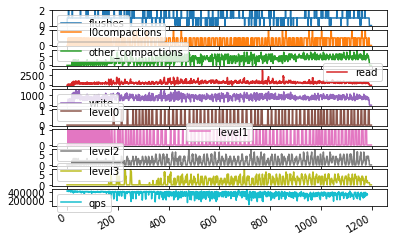

In [108]:
plot_by_num_of_states(list_of_moment_map,0)

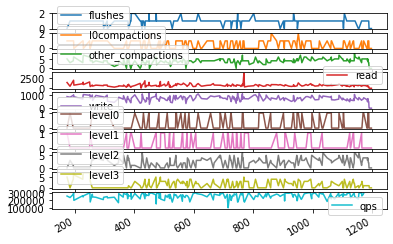

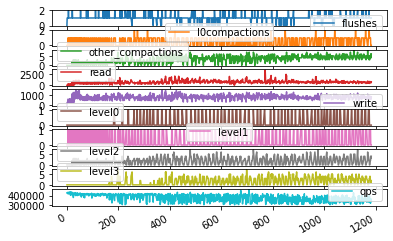

In [109]:
plot_by_num_of_states(list_of_moment_map,1)

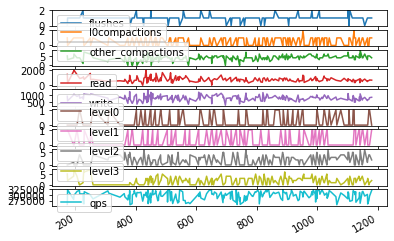

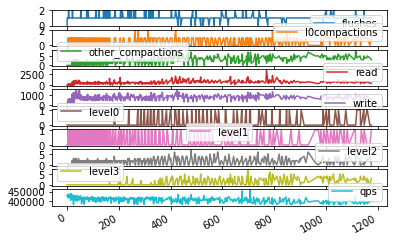

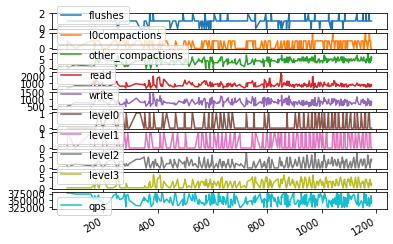

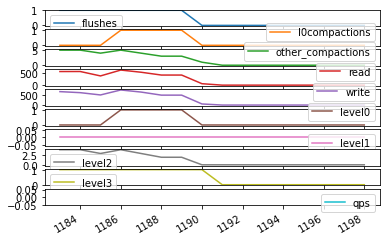

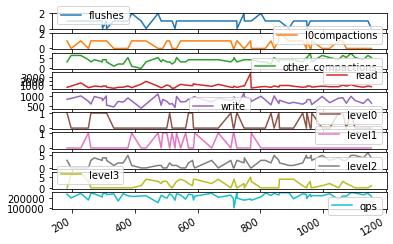

In [110]:
plot_by_num_of_states(list_of_moment_map,4)

1612149123624022
step 0: loss [34139684. 34139696. 21492122. 15795443. 15775397. 11930343.  9628826.
  9617696.  9609007.  9608108.]
step 20: loss [34150692.   34150704.    4469084.5   2649424.    2212751.    1389457.9
  1206617.2   1039640.9    974065.94   973602.  ]
step 40: loss [34138480.   34138492.    2776464.2   1546361.1   1516384.1    869499.94
   703074.44   550957.94   490178.1    459570.03]
step 60: loss [34138452.   34138460.    2398493.2   1334298.5   1081210.1    737543.5
   576855.9    424051.5    366932.12   326192.72]
step 80: loss [34138520.   34138524.    2288443.5   1246978.4    864297.75   584276.3
   523551.7    372009.25   314752.75   271376.94]
step 100: loss [34138610.   34138612.    2237545.    1205163.5    793842.44   551451.3
   493692.78   342162.56   284814.66   241370.62]
step 120: loss [34138656.   34138660.    2211511.2   1181696.     758021.1    531146.9
   474022.5    322509.16   265154.47   221565.4 ]
step 140: loss [34138620.   34138624.    2197247

/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(
/home/jinghuan/anaconda3/envs/anormally_detection/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


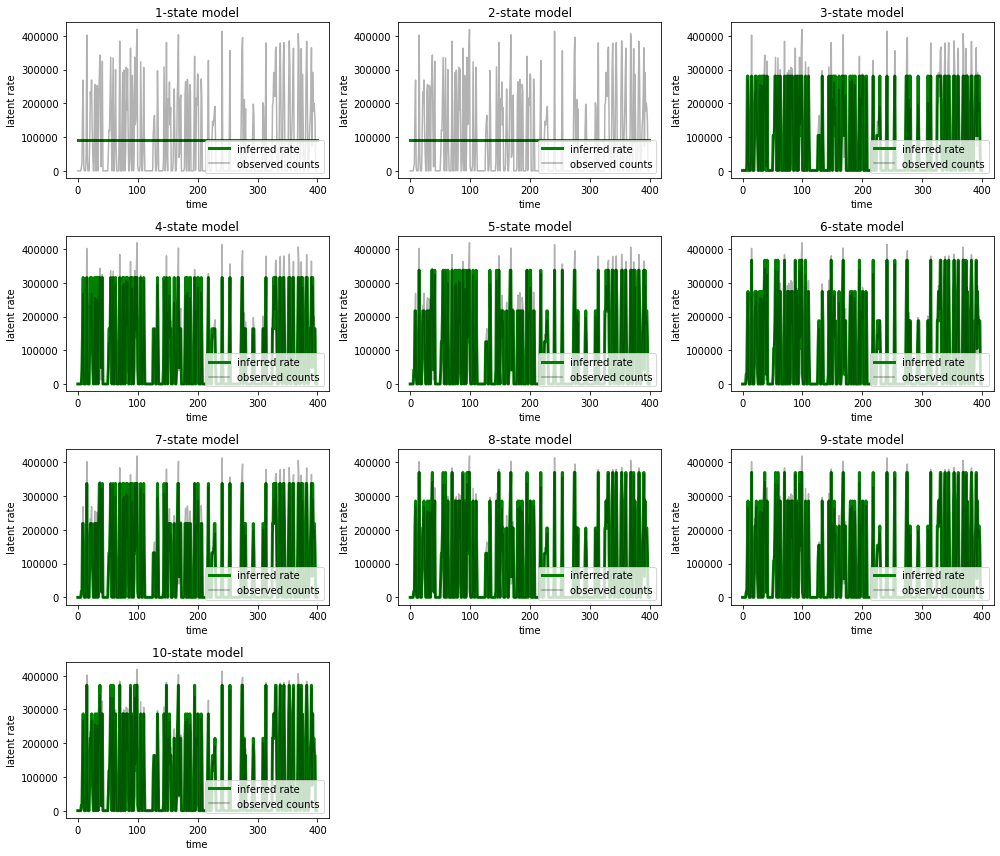

<Figure size 1008x864 with 0 Axes>

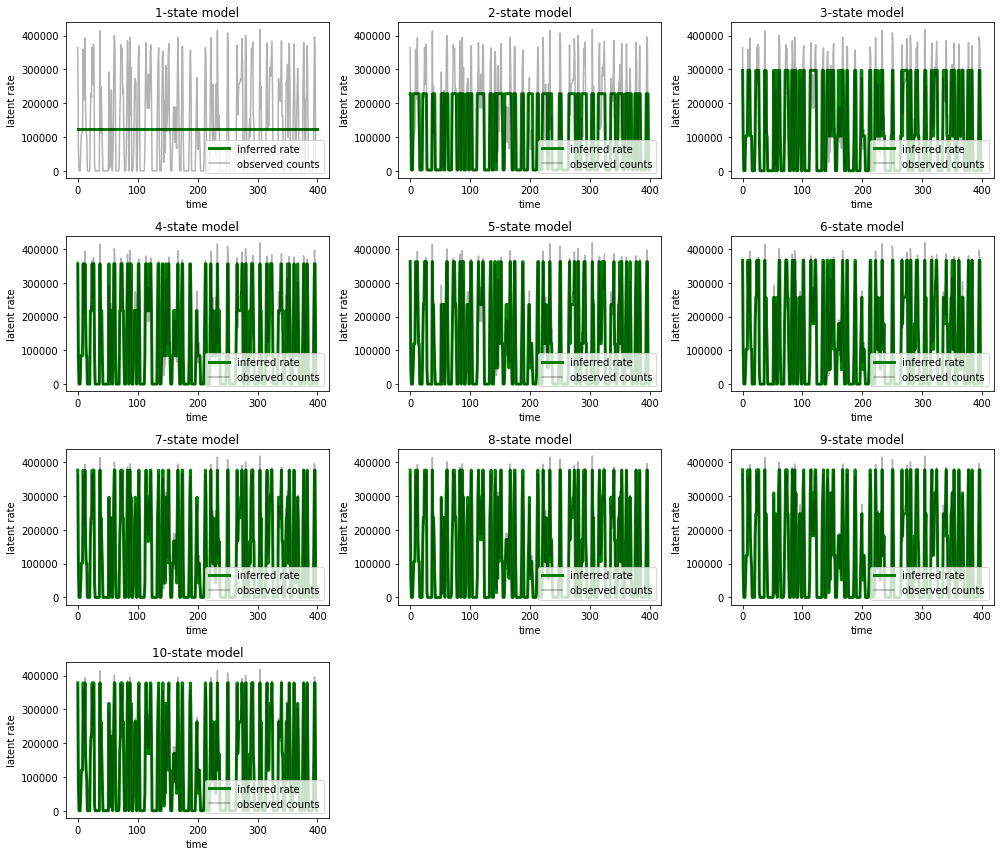

<Figure size 1008x864 with 0 Axes>

In [115]:
# Changing options while running
dirs = get_log_dirs("middle_changing_log")
log_dir = dirs[0]

stdout_file, LOG_file, report_csv = get_log_and_std_files(log_dir)

data_set = load_log_and_qps(LOG_file, report_csv)
bucket_df = vectorize_by_compaction_output_level(data_set)
bucket_df["qps"] = data_set.qps_df["interval_qps"]

observed_counts = bucket_df["qps"].fillna(0).tolist()
observed_counts = np.array(observed_counts).astype(np.float32)

observation_before_changing = observed_counts[200:600]
observation_after_changing = observed_counts[610:1010]
list_of_moment_map_before_changing = get_list_of_moment_map(observation_before_changing)

list_of_moment_map_after_changing = get_list_of_moment_map(observation_after_changing)

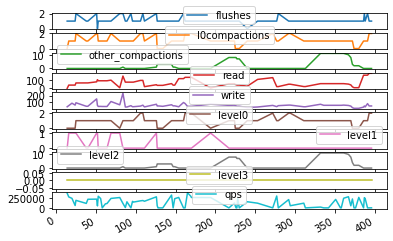

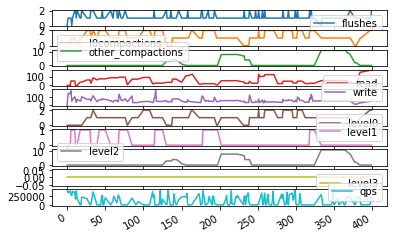

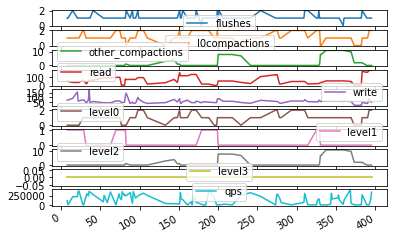

In [121]:
plot_by_num_of_states(list_of_moment_map_before_changing,2)

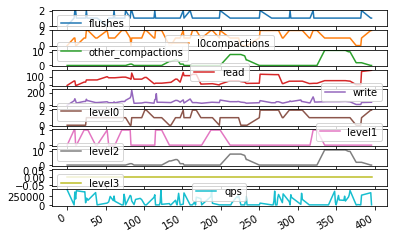

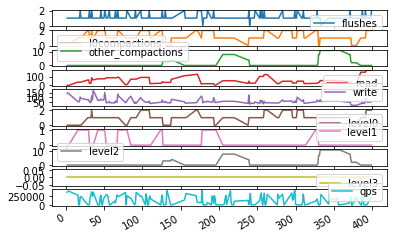

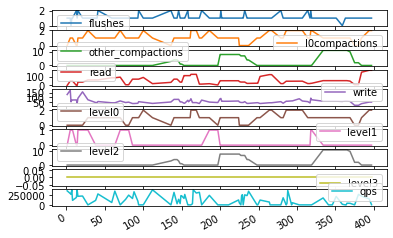

In [119]:
plot_by_num_of_states(list_of_moment_map_after_changing,2)